<a href="https://colab.research.google.com/github/RajAakash/Transformers/blob/main/TabTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tabtransformertf
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
for dirname, _, filenames in os.walk('drive/MyDrive/Kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/Kaggle/sample_submission.csv
drive/MyDrive/Kaggle/test.csv
drive/MyDrive/Kaggle/train.csv


In [5]:
train_df = pd.read_csv('drive/MyDrive/Kaggle/train.csv')
test_df = pd.read_csv('drive/MyDrive/Kaggle/test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [7]:
train_df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [8]:
CATEGORICAL_FEATURES = ['cut', 'color', 'clarity']
NUMERIC_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET_FEATURE = 'price'

In [9]:
sc = StandardScaler()
sc.fit(train_df[NUMERIC_FEATURES])
train_df[NUMERIC_FEATURES]= sc.transform(train_df[NUMERIC_FEATURES])
train_df

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.576255,Premium,F,VS2,0.350768,0.402496,1.401353,1.460456,1.474414,13619
1,1,2.678513,Very Good,J,SI2,0.165874,0.402496,2.113437,2.177120,2.200187,13387
2,2,-0.196003,Ideal,G,VS1,-0.573702,-0.118652,-0.022816,0.008986,-0.049710,2772
3,3,-1.017293,Ideal,G,VS1,-0.203914,-0.639801,-1.203614,-1.188477,-1.196432,666
4,4,1.965288,Premium,G,VS2,0.720555,0.923644,1.743874,1.714463,1.793754,14453
...,...,...,...,...,...,...,...,...,...,...,...
193568,193568,-1.038906,Ideal,D,VVS2,-0.666149,-0.639801,-1.230655,-1.206620,-1.254494,1130
193569,193569,-0.196003,Premium,G,VVS2,-1.405724,0.402496,0.031267,0.045273,-0.093257,2874
193570,193570,-0.131164,Very Good,F,SI1,1.182790,-0.118652,0.004226,0.027129,0.124475,3036
193571,193571,-0.974067,Very Good,D,SI1,0.997896,-1.160949,-1.140517,-1.115903,-1.051277,681


In [10]:
train_data, val_data = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=8)

In [11]:
train_dataset = df_to_dataset(train_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=1024)
val_dataset = df_to_dataset(val_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=1024)

/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [12]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 3/3 [00:00<00:00, 27.53it/s]


In [13]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features=NUMERIC_FEATURES,  # list of numeric features
    categorical_features=CATEGORICAL_FEATURES,  # list of numeric features
    numerical_data=train_df[NUMERIC_FEATURES].values,
    categorical_data=train_df[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass the encoder to the model
ft_model = FTTransformer(
    encoder=ft_linear_encoder,  # Encoder from above
    out_dim=1,  # Number of outputs in final layer
    out_activation='relu',  # Activation function for final layer
)

In [14]:
epochs = 1000
lr = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

ft_model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError()],
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

history = ft_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/1000
152/152 [==============================] - 19s 43ms/step - loss: 63969912.0000 - importances_loss: 32049802.0000 - output_loss: 31920120.0000 - importances_root_mean_squared_error: 5661.2539 - output_root_mean_squared_error: 5649.7896 - val_loss: 63603100.0000 - val_importances_loss: 31948260.0000 - val_output_loss: 31654842.0000 - val_importances_root_mean_squared_error: 5652.2798 - val_output_root_mean_squared_error: 5626.2637
Epoch 2/1000
152/152 [==============================] - 6s 34ms/step - loss: 63443736.0000 - importances_loss: 32049788.0000 - output_loss: 31393960.0000 - importances_root_mean_squared_error: 5661.2554 - output_root_mean_squared_error: 5603.0312 - val_loss: 62737584.0000 - val_importances_loss: 31948260.0000 - val_output_loss: 30789326.0000 - val_importances_root_mean_squared_error: 5652.2798 - val_output_root_mean_squared_error: 5548.8130
Epoch 3/1000
152/152 [==============================] - 7s 38ms/step - loss: 62135884.0000 - importances_loss

In [15]:
history = history.history

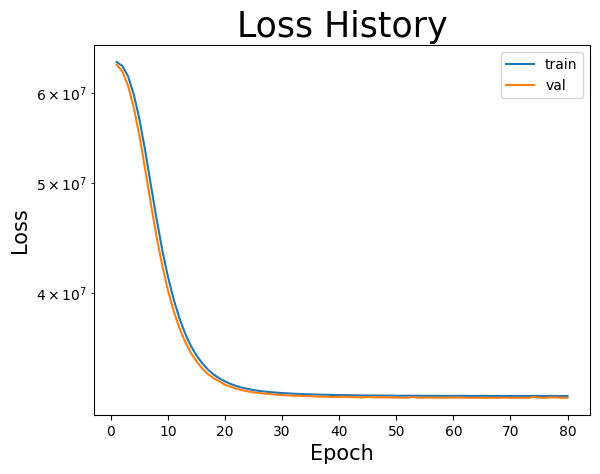

In [17]:
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='train')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='val')
plt.yscale('log')
plt.title('Loss History', fontsize=25)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.show()

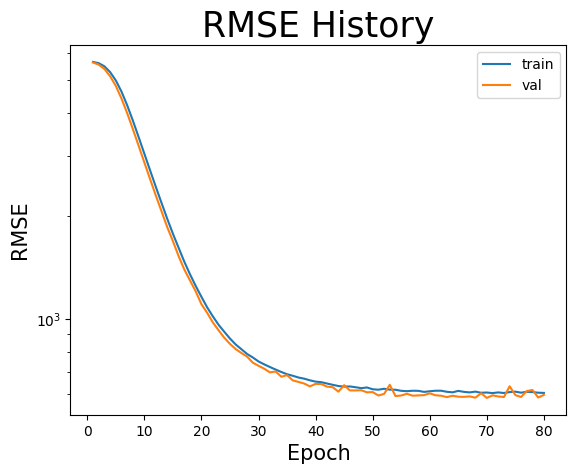

In [19]:
plt.plot(range(1, len(history['output_root_mean_squared_error'])+1), history['output_root_mean_squared_error'], label='train')
plt.plot(range(1, len(history['val_output_root_mean_squared_error'])+1), history['val_output_root_mean_squared_error'], label='val')
plt.yscale('log')
plt.title('RMSE History', fontsize=25)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.legend()
plt.show()

38/38 [==============================] - 3s 30ms/step


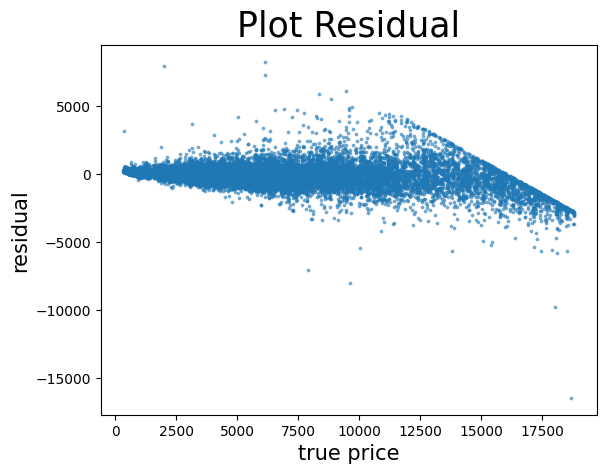

In [20]:
y_pred = ft_model.predict(val_dataset)['output'].reshape(-1)
y_true = val_data['price'].values
residual = y_pred - y_true
plt.scatter(y_true, residual, s=3, alpha=0.5)
plt.title('Plot Residual', fontsize=25)
plt.xlabel('true price', fontsize=15)
plt.ylabel('residual', fontsize=15)
plt.show()

In [21]:
test_df[NUMERIC_FEATURES]= sc.transform(test_df[NUMERIC_FEATURES])

In [22]:
test_dataset = df_to_dataset(test_df, shuffle=False)

/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [23]:
y_pred = ft_model.predict(test_dataset)['output'].reshape(-1)

253/253 [==============================] - 5s 18ms/step


In [25]:
submission_df = pd.read_csv('drive/MyDrive/Kaggle/sample_submission.csv')
submission_df['price'] = y_pred
submission_df.to_csv('submission.csv', index=False)